In [20]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
from cv2.quality import QualitySSIM

# Function to plot RGB distribution
def plot_rgb_distribution(images):
    num_imgs = len(images)
    fig, axes = plt.subplots(2, num_imgs, figsize=(20, 10), sharey='row')

    for i, image in enumerate(images):
        # Show the image
        axes[0, i].imshow(image)
        # axes[0, i].set_title(f'Image {i+1}')

        # Extract 2-D arrays of the RGB channels: red, green, blue
        red, green, blue = image[:, :, 0], image[:, :, 1], image[:, :, 2]

        # Flatten the 2-D arrays of the RGB channels into 1-D
        red_pixels = red.flatten() / 255.0  # Normalize values to range [0, 1]
        green_pixels = green.flatten() / 255.0
        blue_pixels = blue.flatten() / 255.0

        # Calculate histograms of pixels for each channel
        red_px = np.histogram(red_pixels, bins=256, range=[0, 1])
        green_px = np.histogram(green_pixels, bins=256, range=[0, 1])
        blue_px = np.histogram(blue_pixels, bins=256, range=[0, 1])

        # Plot histograms
        axes[1, i].plot(red_px[1][:256], red_px[0], color='r', label='Red')
        axes[1, i].plot(green_px[1][:256], green_px[0], color='g', label='Green')
        axes[1, i].plot(blue_px[1][:256], blue_px[0], color='b', label='Blue')
        # axes[1, i].set_xlabel('Intensity')
        # axes[1, i].set_ylabel('Frequency (log scale)')
        axes[1, i].set_xticks(np.linspace(0, 1, 17))
        axes[1, i].set_xticklabels(range(0, 257, 16))
        axes[1, i].set_yscale('log')
        # axes[1, i].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# images = [cv2.imread(path) for path in image_paths]
# plot_rgb_distribution(images)


In [21]:
def denoise_image(image, filters):
    for filter in filters:
        for _ in range(filter['n_iter']):
            match filter['name']:
                case "mean":
                    '''
                    {"ksize" : 15}
                    '''
                    k_size = filter['params']['ksize']
                    mean_kernel = np.ones([k_size, k_size])/(k_size**2)
                    image = cv2.filter2D(image, -1, mean_kernel)

                case "median":
                    '''
                    {"ksize" : 11}
                    '''
                    image = cv2.medianBlur(image, **filter['params'])

                case "bilateral":
                    '''
                    {"d" : 3,
                    "sigmaColor" : 2,
                    "sigmaSpace" : 1.5}
                    '''
                    image = cv2.bilateralFilter(image, **filter['params'])

                case 'gaussian':
                    '''
                    {"sigmaX" : 2}
                    '''
                    sigmaX = filter['params']['sigmaX']
                    ksize = 2*int(np.ceil(3*sigmaX)) + 1
                    image = cv2.GaussianBlur(image, (ksize, ksize), sigmaX)

                case 'non_local_means':
                    '''
                    {'templateWindowSize':5,"searchWindowSize":21, "h":3, "hColor": 20}
                    '''
                    image = cv2.fastNlMeansDenoisingColored(image, **filter['params'])

                case 'canny':
                    '''
                    {'threshold1':5,"threshold2":21}
                    '''
                    image = cv2.Canny(image, **filter['params'])

                case 'sharpen':
                    kernel = np.array([[0, -1, 0],
                                       [-1, 5, -1],
                                       [0, -1, 0]])
                    image = cv2.filter2D(image, -1, kernel=kernel)

                case 'emboss':
                    kernel = np.array([[-2, -1, 0],
                                       [-1, 1, 1],
                                       [0, 1, 2]])
                    image = cv2.filter2D(image, -1, kernel=kernel)
                case _: pass
    return image

def normalize(image):
    return (image.astype(float)*255.0/225).astype('uint8')

In [22]:
filters = [
    {'name': "median",
        "n_iter": 1,
        "params": {"ksize": 3}
     },
    {'name': "median",
        "n_iter": 0,
        "params": {"ksize": 5}
     },
    {'name': "median",
        "n_iter": 1,
        "params": {"ksize": 7}
     },
    {'name': "median",
        "n_iter": 0,
        "params": {"ksize": 9}
     },
]

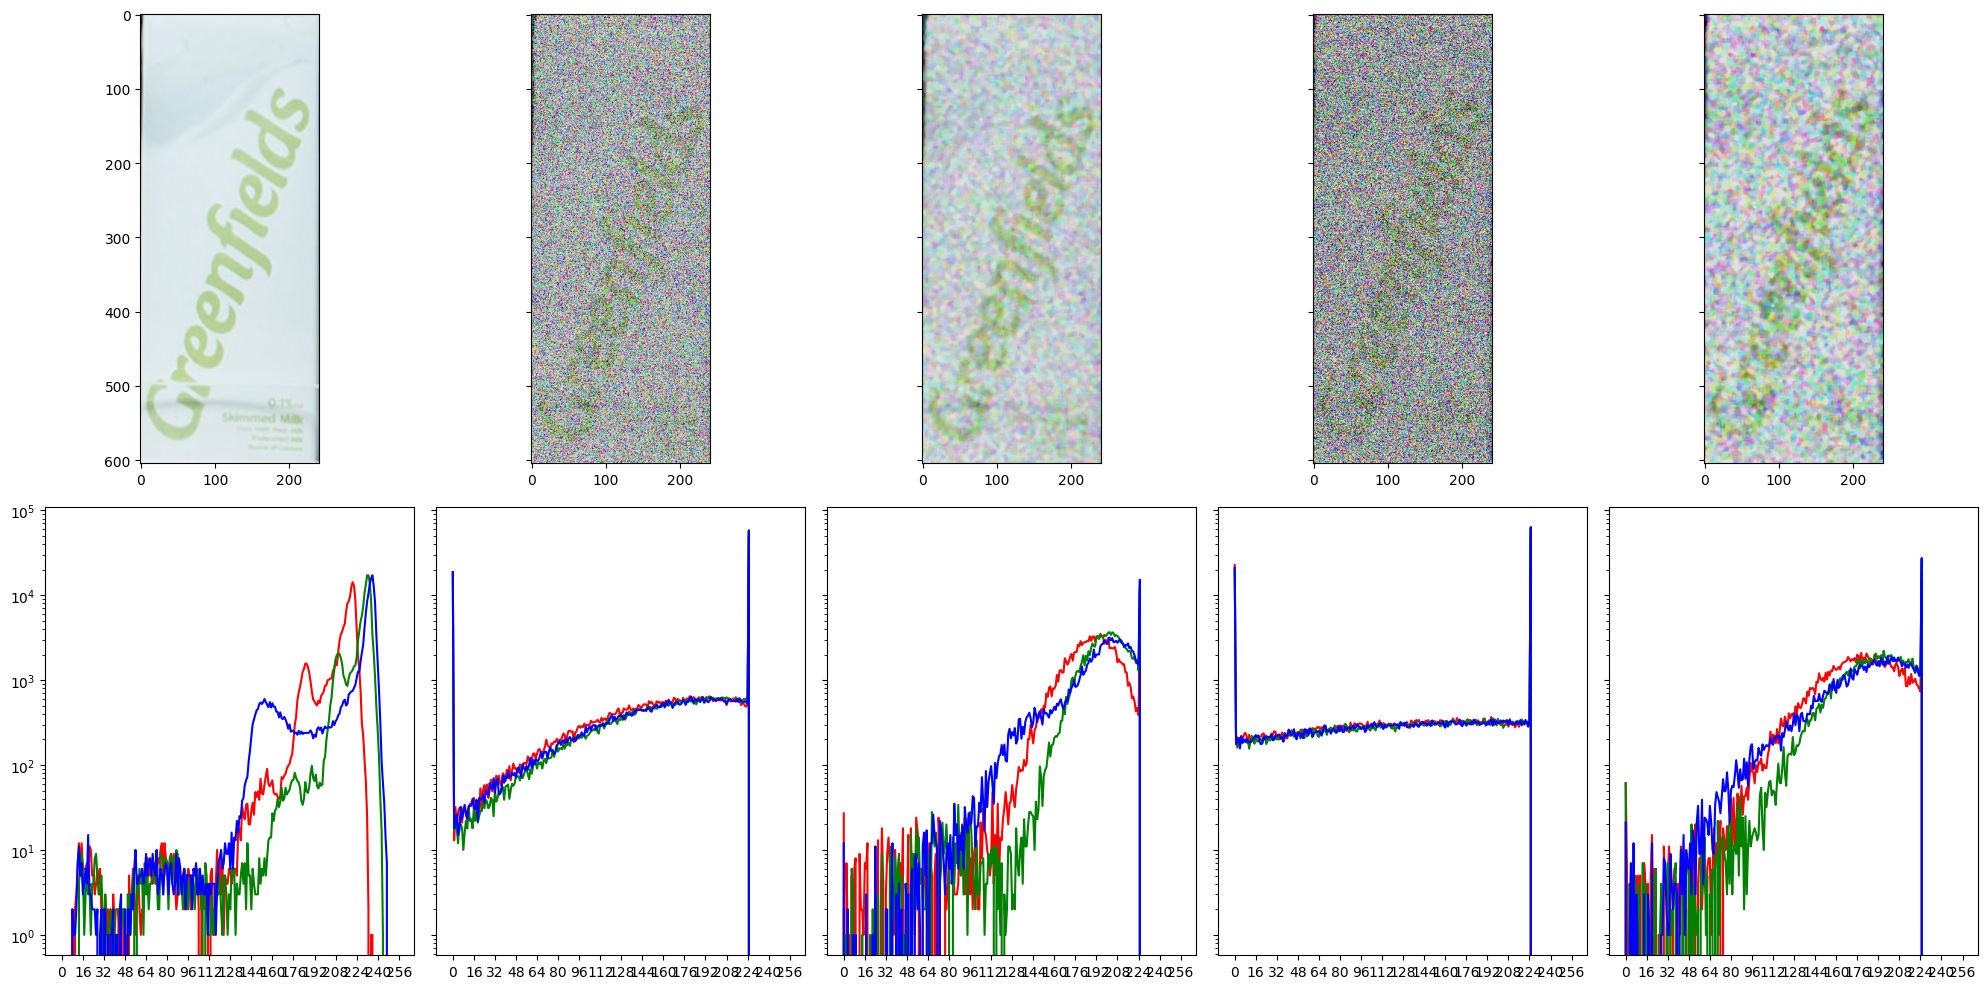

In [117]:
img_scene=cv2.imread(f'../dataset/scenes/scene{12}.png')[100:,1360:1600,::-1]
img_scene_denoise=denoise_image(img_scene,filters)

img_no_noise=cv2.imread(f'../dataset/models/ref{18}.png')[:,:,::-1]
img_no_noise=cv2.resize(img_no_noise,(img_scene.shape[1],img_scene.shape[0]),interpolation= 1)
noise = np.random.normal(loc=30,scale=180, size=img_no_noise.shape)
# noise2 = np.random.randint(0,150, size=img_no_noise.shape)
img_noise=img_no_noise-noise
img_clip=np.clip(img_noise,0,225).astype(np.uint8)
img_denoise=denoise_image(img_clip,filters)
# print(np.abs(np.mean(img_scene)-np.mean(img_no_noise)),np.abs(np.mean(img_scene)-np.mean(img_noise)))
plot_rgb_distribution(
                        [img_no_noise]+
                        [img_scene]+
                        [img_scene_denoise]+
                        # [img_noise]+
                        [img_clip]+
                        [img_denoise]
                      )

In [59]:
ssim=QualitySSIM()
print(ssim.compute(img_scene_denoise,img_denoise)[0])

(0.2527913342147473, 0.25441303926743314, 0.27077601495751846, 0.0)
